# Preprocess

In addition to loading datasets, 🤗 Datasets other main goal is to offer a diverse set of preprocessing functions to get a dataset into an appropriate format for training with your machine learning framework.

There are many possible ways to preprocess a dataset, and it all depends on your specific dataset. Sometimes you may need to rename a column, and other times you might need to unflatten nested fields. 🤗 Datasets provides a way to do most of these things. But in nearly all preprocessing cases, depending on your dataset modality, you’ll need to:

    Tokenize a text dataset.
    Resample an audio dataset.
    Apply transforms to an image dataset.
The last preprocessing step is usually setting your dataset format to be compatible with your machine learning framework’s expected input format.

In this tutorial, you’ll also need to install the 🤗 Transformers library:


pip install transformers
Grab a dataset of your choice and follow along!

## Tokenize text
Models cannot process raw text, so you’ll need to convert the text into numbers. Tokenization provides a way to do this by dividing text into individual words called tokens. Tokens are finally converted to numbers.

Check out the Tokenizers section in Chapter 2 of the Hugging Face course to learn more about tokenization and different tokenization algorithms.

1. Start by loading the rotten_tomatoes dataset and the tokenizer corresponding to a pretrained BERT model. Using the same tokenizer as the pretrained model is important because you want to make sure the text is split in the same way.



from transformers import AutoTokenizer
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes", split="train")

2. Call your tokenizer on the first row of text in the dataset:



dataset[0]["text"]

tokenizer(dataset[0]["text"])

The tokenizer returns a dictionary with three items:

    input_ids: the numbers representing the tokens in the text.
    token_type_ids: indicates which sequence a token belongs to if there is more than one sequence.
    attention_mask: indicates whether a token should be masked or not.
These values are actually the model inputs.

3. The fastest way to tokenize your entire dataset is to use the map() function. This function speeds up tokenization by applying the tokenizer to batches of examples instead of individual examples. Set the batched parameter to True:

def tokenization(example):
    return tokenizer(example["text"])

dataset = dataset.map(tokenization, batched=True)

4. Set the format of your dataset to be compatible with your machine learning framework:

### for Pytorch
Use the set_format() function to set the dataset format to be compatible with PyTorch:



dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
dataset.format['type']

### for TensorFlow

Use the to_tf_dataset() function to set the dataset format to be compatible with TensorFlow. You’ll also need to import a data collator from 🤗 Transformers to combine the varying sequence lengths into a single batch of equal lengths:

In [1]:
#only run once if not currently installed
#!pip install tensorflow

In [2]:
#i am not using TF so i am not running this 

#from transformers import DataCollatorWithPadding

#data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
#tf_dataset = dataset.to_tf_dataset(
#    columns=["input_ids", "token_type_ids", "attention_mask"],
#    label_cols=["label"],
#    batch_size=2,
#    collate_fn=data_collator,
#    shuffle=True
#)

5. The dataset is now ready for training with your machine learning framework!

## Resample audio signals
Audio inputs like text datasets need to be divided into discrete data points. This is known as sampling; the sampling rate tells you how much of the speech signal is captured per second. It is important to make sure the sampling rate of your dataset matches the sampling rate of the data used to pretrain the model you’re using. If the sampling rates are different, the pretrained model may perform poorly on your dataset because it doesn’t recognize the differences in the sampling rate.

1. Start by loading the MInDS-14 dataset, the Audio feature, and the feature extractor corresponding to a pretrained Wav2Vec2 model:

#disable auto decoding due to problems
from transformers import AutoFeatureExtractor
from datasets import load_dataset, Audio

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")
dataset = load_dataset("PolyAI/minds14", "en-US", split="train")

2. Index into the first row of the dataset. When you call the audio column of the dataset, it is automatically decoded and resampled:

In [6]:
"""
Working solution for HuggingFace audio dataset tutorial on macOS
Bypasses the broken torchcodec/datasets audio loading
"""

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import subprocess
import tempfile
import numpy as np
import torch

def load_minds14_sample(sample_index=0, target_sr=16000):
    """
    Load MInDS-14 audio sample with proper resampling.
    
    Args:
        sample_index: Which sample to load (0-562 for en-US train split)
        target_sr: Target sampling rate (16000 for Wav2Vec2)
    
    Returns:
        tuple: (waveform_array, sampling_rate, audio_tensor)
    """
    from huggingface_hub import hf_hub_download
    import pandas as pd
    
    # Download parquet (cached after first time)
    parquet_file = hf_hub_download(
        repo_id="PolyAI/minds14",
        filename="en-US/train-00000-of-00001.parquet",
        repo_type="dataset"
    )
    
    # Get audio bytes
    df = pd.read_parquet(parquet_file)
    audio_bytes = df.iloc[sample_index]['audio']['bytes']
    
    # Temp files
    with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp_in:
        tmp_in.write(audio_bytes)
        input_path = tmp_in.name
    
    with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp_out:
        output_path = tmp_out.name
    
    try:
        # FFmpeg: decode + resample
        subprocess.run([
            'ffmpeg', '-i', input_path, '-ar', str(target_sr),
            '-ac', '1', '-f', 'wav', '-y', output_path
        ], capture_output=True, check=True)
        
        # Read WAV
        import wave
        with wave.open(output_path, 'rb') as wav:
            sr = wav.getframerate()
            frames = wav.readframes(wav.getnframes())
            waveform = np.frombuffer(frames, dtype=np.int16).astype(np.float32) / 32768.0
        
        # Return array, sr, and tensor
        tensor = torch.tensor(waveform).unsqueeze(0)
        return waveform, sr, tensor
    
    finally:
        if os.path.exists(input_path): os.unlink(input_path)
        if os.path.exists(output_path): os.unlink(output_path)


# Test it
waveform, sr, audio_tensor = load_minds14_sample(0, target_sr=16000)
print(f"✓ Loaded sample: {waveform.shape}, {sr}Hz")
print(f"✓ Tensor ready for model: {audio_tensor.shape}")
print("\n🎉 SUCCESS! This replaces the broken dataset audio loading.")

✓ Loaded sample: (173398,), 16000Hz
✓ Tensor ready for model: torch.Size([1, 173398])

🎉 SUCCESS! This replaces the broken dataset audio loading.


In [8]:
# Create a dict that matches the tutorial's audio format
audio = {
    'array': waveform,
    'sampling_rate': sr
}

print(audio['sampling_rate'])
# Output: 8000

16000


3. Reading a dataset card is incredibly useful and can give you a lot of information about the dataset. A quick look at the MInDS-14 dataset card tells you the sampling rate is 8kHz. Likewise, you can get many details about a model from its model card. The Wav2Vec2 model card says it was sampled on 16kHz speech audio. This means you’ll need to upsample the MInDS-14 dataset to match the sampling rate of the model.

Use the cast_column() function and set the sampling_rate parameter in the Audio feature to upsample the audio signal. When you call the audio column now, it is decoded and resampled to 16kHz:

In [9]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))
audio = dataset[0]["audio"]
print(audio)
audio.get_all_samples().sample_rate

NameError: name 'dataset' is not defined

In [10]:
waveform_resampled, sr_resampled, _ = load_minds14_sample(0, target_sr=16000)

audio = {
    'array': waveform_resampled,
    'sampling_rate': sr_resampled
}

print(f"Array shape: {audio['array'].shape}")
print(f"Sampling rate: {audio['sampling_rate']}")

Array shape: (173398,)
Sampling rate: 16000


4. Use the map() function to resample the entire dataset to 16kHz. This function speeds up resampling by applying the feature extractor to batches of examples instead of individual examples. Set the batched parameter to True:

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x.get_all_samples().data for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs

dataset = dataset.map(preprocess_function, batched=True)

5. The dataset is now ready for training with your machine learning framework!

## Apply data augmentations
The most common preprocessing you’ll do with image datasets is data augmentation, a process that introduces random variations to an image without changing the meaning of the data. This can mean changing the color properties of an image or randomly cropping an image. You are free to use any data augmentation library you like, and 🤗 Datasets will help you apply your data augmentations to your dataset.

1. Start by loading the Beans dataset, the Image feature, and the feature extractor corresponding to a pretrained ViT model:

In [1]:
from transformers import AutoFeatureExtractor
from datasets import load_dataset, Image

#feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
dataset = load_dataset("AI-Lab-Makerere/beans", split="train")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

2. Index into the first row of the dataset. When you call the image column of the dataset, the underlying PIL object is automatically decoded into an image.

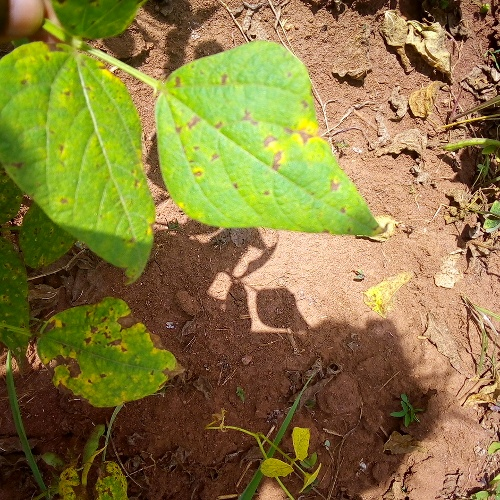

In [2]:
dataset[0]["image"]

Most image models expect the image to be in the RGB mode. The Beans images are already in the RGB mode, but if your dataset contains images in a different mode, you can use the cast_column() function to set the mode to RGB:

In [3]:
dataset = dataset.cast_column("image", Image(mode="RGB"))

3. Now let’s apply data augmentations to your images. 🤗 Datasets works with any augmentation library, and in this example we’ll use Albumentations.

Albumentations is a popular image augmentation library that provides a rich set of transforms including spatial-level transforms, pixel-level transforms, and mixing-level transforms.

Install Albumentations:

In [4]:
import albumentations as A
import numpy as np
from PIL import Image

transform = A.Compose([
    A.RandomCrop(height=256, width=256, pad_if_needed=True, p=1),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.5)
])

5. Since 🤗 Datasets uses PIL images but Albumentations expects NumPy arrays, you need to convert between formats:

In [5]:
def albumentations_transforms(examples):
    # Apply Albumentations transforms
    transformed_images = []
    for image in examples["image"]:
        # Convert PIL to numpy array (OpenCV format)
        image_np = np.array(image.convert("RGB"))
        
        # Apply Albumentations transforms
        transformed_image = transform(image=image_np)["image"]
        
        # Convert back to PIL Image
        pil_image = Image.fromarray(transformed_image)
        transformed_images.append(pil_image)
    
    examples["pixel_values"] = transformed_images
    return examples


6. Apply the transform using with_transform():

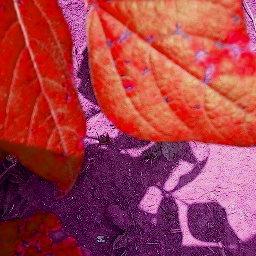

In [6]:
dataset = dataset.with_transform(albumentations_transforms)
dataset[0]["pixel_values"]

Key points when using Albumentations with 🤗 Datasets:

Convert PIL images to NumPy arrays before applying transforms
Albumentations returns a dictionary with the transformed image under the “image” key
Convert the result back to PIL format after transformation
7. The dataset is now ready for training with your machine learning framework!